# VAMOS quickstart: user-friendly API

This notebook demonstrates the user-friendly API for quick optimization tasks.
For the full AutoNSGA-II configuration (external archive, BLX-alpha, non-uniform mutation),
we use the `optimize` API because `run_nsgaii` does not expose those knobs.


In [1]:
from vamos import optimize, OptimizeConfig, NSGAIIConfig, ZDT1, make_problem_selection
import matplotlib.pyplot as plt
import numpy as np

## 1. Minimal Example (ZDT1)

Here is the absolute simplest way to run an optimization: just provide the problem name.

In [2]:
SEED = 42

problem = ZDT1(32)

result = optimize(
    OptimizeConfig(
        problem=problem,
        algorithm="nsgaii",
        algorithm_config=(
            NSGAIIConfig()
            .pop_size(56)
            .offspring_size(14)
            .crossover("blx_alpha", prob=0.88, alpha=0.94)
            .mutation("non_uniform", prob="0.45/n", perturbation=0.3)
            .selection("tournament", pressure=9)
            .repair("clip")
            .external_archive(size=100, archive_type="crowding")
            .engine("numpy")
            .fixed()
        ),
        termination=("n_eval", 25000),
        seed=SEED,
    )
)

In [3]:
result.summary()

=== Optimization Result ===
Solutions: 56
Objectives: 2

Objective ranges:
  f1: [0.000000, 1.000000]
  f2: [0.000000, 1.000000]


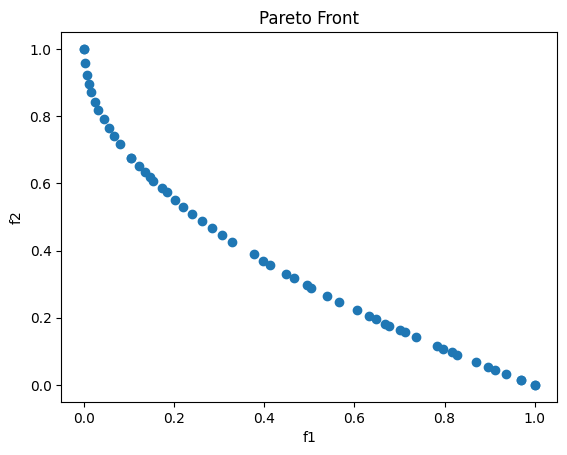

<Axes: title={'center': 'Pareto Front'}, xlabel='f1', ylabel='f2'>

In [4]:
result.plot()

In [5]:
# Knee point (balanced trade-off)
knee = result.best("knee")
print("Knee point:")
print(f"  Objectives: {knee['F']}")
print(f"  Index: {knee['index']}")

Knee point:
  Objectives: [0.24055774 0.50953314]
  Index: 17


In [6]:
# Export to pandas
df = result.to_dataframe()
df.head(3)

,f1,f2,x1,x2,x3,x4,x5,x6,x7,x8,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Canonical Engine Path (Serializable Config)

This is the canonical path that powers the CLI, StudyRunner, and automation.
The config is a plain dict (YAML/JSON friendly), so it also works for algorithms without quick wrappers.


In [7]:
# Canonical engine path: build a config, serialize it, then run optimize().
cfg = (
    NSGAIIConfig()
    .pop_size(100)
    .crossover("sbx", prob=0.9, eta=20.0)
    .mutation("pm", prob="1/n", eta=20.0)
    .selection("tournament", pressure=2)
    .engine("numpy")
    .fixed()
)

cfg_dict = cfg.to_dict()  # YAML/JSON for CLI/StudyRunner; OptimizeConfig uses cfg
canonical_result = optimize(
    OptimizeConfig(
        problem=problem,
        algorithm="nsgaii",
        algorithm_config=cfg,
        termination=("n_eval", 1000),
        seed=SEED,
    )
)
canonical_result.summary()

=== Optimization Result ===
Solutions: 18
Objectives: 2

Objective ranges:
  f1: [0.000183, 0.905841]
  f2: [1.493722, 3.943579]


## 3. Encodings at a Glance

These keys map directly to CLI/config usage and show the supported encodings.


In [8]:
encoding_keys = ["zdt1", "bin_knapsack", "int_alloc", "tsp6", "mixed_design"]
print("key         | encoding   | label")
print("-" * 50)
for key in encoding_keys:
    selection = make_problem_selection(key)
    print(f"{key:12} | {selection.spec.encoding:9} | {selection.spec.label}")

key         | encoding   | label
--------------------------------------------------
zdt1         | continuous | ZDT1
bin_knapsack | binary    | Binary Knapsack
int_alloc    | integer   | Integer Resource Allocation
tsp6         | permutation | TSP (6 cities)
mixed_design | mixed     | Mixed Design


## 4. Advanced Usage

For full control, use the `optimize` API with an explicit NSGA-II configuration.
Below we rerun with the same AutoNSGA-II settings but a shorter budget.


In [ ]:
result2 = optimize(
    OptimizeConfig(
        problem=problem,
        algorithm="nsgaii",
        algorithm_config=(
            NSGAIIConfig()
            .pop_size(56)
            .offspring_size(14)
            .crossover("blx_alpha", prob=0.88, alpha=0.94)
            .mutation("non_uniform", prob="0.45/n", perturbation=0.3)
            .selection("tournament", pressure=9)
            .repair("clip")
            .external_archive(size=100, archive_type="crowding")
            .engine("moocore")
            .fixed()
        ),
        termination=("n_eval", 2000),
        seed=SEED,
    )
)
result2.summary()

=== Optimization Result ===
Solutions: 56
Objectives: 2

Objective ranges:
  f1: [0.000000, 1.000000]
  f2: [0.154399, 1.290323]


## 5. Comparing Results

We can easily compare multiple result objects.

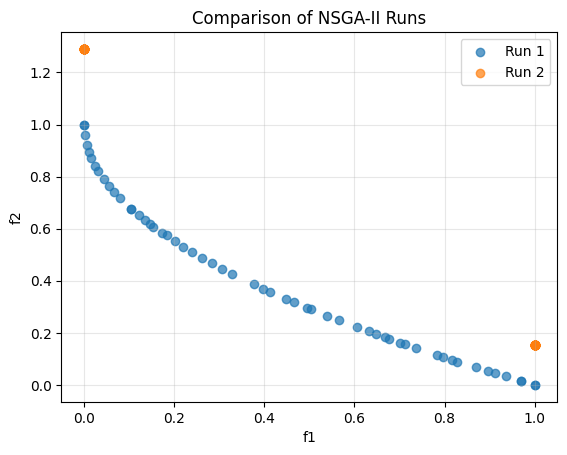

In [10]:
plt.figure()
for label, res in (("Run 1", result), ("Run 2", result2)):
    F = res.front()
    if F is None or not F.size:
        continue
    plt.scatter(F[:, 0], F[:, 1], label=label, alpha=0.7)

plt.title("Comparison of NSGA-II Runs")
plt.xlabel("f1")
plt.ylabel("f2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Solving a Combinatorial Problem (TSP)

VAMOS isn't just for continuous problems. Here is how to solve a Permutation problem like the Travelling Salesman Problem (TSP).
We use the **Order Crossover (OX)** and **Swap Mutation** operators, which are automatically selected for permutation variables.

In [11]:
from vamos.foundation.problem.tsp import TSPProblem, _default_coordinates
from vamos import optimize, OptimizeConfig, NSGAIIConfig

# Create a small TSP instance
coords = _default_coordinates()
tsp_prob = TSPProblem(coordinates=coords)
print(f"Created TSP with {len(coords)} cities.")

# Run optimization
print("Optimizing TSP Tour...")
tsp_res = optimize(
    OptimizeConfig(
        problem=tsp_prob,
        algorithm="nsgaii",
        algorithm_config=(
            NSGAIIConfig()
            .pop_size(50)
            .crossover("ox", prob=0.9)  # Order crossover for permutations
            .mutation("swap", prob="2/n")  # Swap mutation for permutations
            .selection("tournament", pressure=2)
            .engine("numpy")  # Use NumPy engine (Python loops for TSP)
            .fixed()
        ),
        termination=("n_eval", 2000),
        seed=42,
    )
)

# Visualize the Best Tour
# Objective 0 is Total Distance
best_idx = np.argmin(tsp_res.F[:, 0])
best_tour = tsp_res.X[best_idx].astype(int)
best_dist = tsp_res.F[best_idx, 0]

print(f"Best Tour Length: {best_dist:.4f}")
print(f"Tour Indices: {best_tour}")

# Plotting the tour
plt.figure(figsize=(6, 6))
# Plot cities
plt.scatter(coords[:, 0], coords[:, 1], c="red", s=100, zorder=2)
for i, (x, y) in enumerate(coords):
    plt.text(x, y + 0.05, str(i), fontsize=12, ha="center")

# Plot edges
tour_coords = coords[best_tour]
# Close the loop
tour_coords = np.vstack([tour_coords, tour_coords[0]])
plt.plot(tour_coords[:, 0], tour_coords[:, 1], "b-", linewidth=2, zorder=1)

plt.title(f"Best TSP Tour (Length={best_dist:.2f})")
plt.grid(True, alpha=0.3)
plt.axis("equal")
plt.show()

Created TSP with 6 cities.
Optimizing TSP Tour...


ValueError: NSGA-II configuration missing required fields: crossover, mutation, selection